In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import default_rng

from sklearn.cluster import KMeans

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [85]:
def gen_views(cluster_scheme, n_rows=10):
    """cluster scheme takes the form of: [(n_clusters, n_columns), (n_clusters, n_colums)]"""
    views = []
    for n_clusters, n_cols in cluster_scheme:
        views.append(gen_view(n_rows, n_clusters, n_cols)) 

    return np.concatenate(views, axis=1)

def gen_view(n_rows, n_clusters=2, n_cols=1, spacing=3, scale=.5):
    rng = default_rng()

    cluster_lengths = [n_rows // n_clusters for i in range(n_clusters)]
    cluster_lengths[0] += n_rows % n_clusters

    clusters = []

    for i, cluster_len in enumerate(cluster_lengths):
        clusters.append(rng.normal(loc=spacing*i, scale=scale, size=(n_cols, cluster_len)))

    return np.concatenate(clusters, axis=1).T

def pairwise_similarity(arr, bw=.3):
    """return lower triangular of the pairwise similarity matrix of an array"""
    torch_ltri_idx = torch.tril(torch.ones(len(arr), len(arr)), diagonal=-1) == 1
    
    arr = arr.reshape(-1, 1)
    D = torch.cdist(arr, arr, p=2)
    b = torch.quantile(D, bw, axis=0)
    S = torch.exp(-D/b)

    return S[torch_ltri_idx].unsqueeze(0)
    
def CrossEntropyTorch(S_ltr, P_ltr, One_Minus_S=None):
    if One_Minus_S is None:
        One_Minus_S = (1 - S_ltr)
        
    CEntropy = - S_ltr * torch.log(P_ltr) - One_Minus_S * torch.log(1 - P_ltr)
    loss = torch.sum(CEntropy)

    return loss

In [73]:
"""donut"""
# big_norm = default_rng().normal(loc=0, scale=1, size=(1000, 2))
# donut = big_norm[big_norm[:, 0]**2 + big_norm[:, 1]**2 > .7]
# donut = donut[donut[:, 0]**2 + donut[:, 1]**2 < 2]

# inner_ring = default_rng().normal(loc=0, scale=.1, size=donut.shape)

# bundt_cake = np.concatenate((donut, inner_ring), axis=1)
# data=bundt_cake

'donut'

<AxesSubplot: >

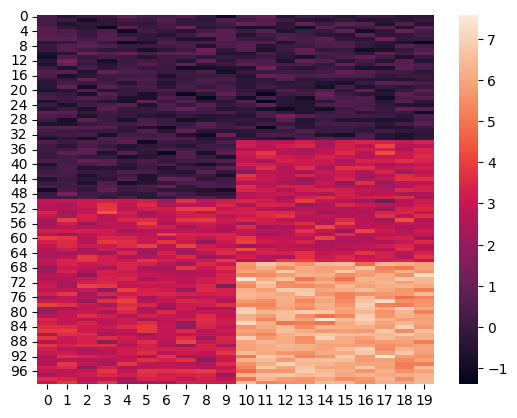

In [74]:
data = torch.from_numpy(gen_views([(2, 10), (3, 10)], 100))
n_rows, n_cols = data.shape

# to fit
n_clusters = min(n_rows, 10)
n_views = min(n_cols, 10)

sns.heatmap(data)

In [75]:
"""initialize"""
bw = .3

# lower triangular pairwise similarity matrix for each feature
ltri_s_mats = torch.vstack([pairwise_similarity(data[:, col_i], bw=bw) for col_i in range(n_cols)])

# initialize eta with K-means
km_fit = KMeans(n_views).fit_predict(torch.log(ltri_s_mats))
eta_ini = torch.eye(n_views)[km_fit]
eta_ini = (eta_ini + 1/n_cols) / (1 + n_views/n_cols)

# eta: p(column in view)
eta = eta_ini
lam = (torch.ones(n_views) / n_views)

# w_i: p(row in each cluster) for view i
W0_list = [torch.rand(n_rows, n_clusters, requires_grad=True, device=device, dtype=dtype) for view_i in range(n_views)]

d:\Ami\Environments\sith_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [76]:
ltri_idx_torch = torch.tril(torch.ones(n_rows, n_rows), diagonal=-1) == 1
alpha0 = 0.1
tau = 1 # regularization?

def E_step(eta, P_mats, lam, s_mat):
    loss_mat = torch.zeros(size=(n_cols, n_views))
    P_mats = P_mats.detach().cpu()

    for col_i in range(n_cols):
        for view_i in range(n_views):
            loss_mat[col_i, view_i] = CrossEntropyTorch(s_mat[col_i], P_mats[view_i])

    eta = torch.softmax((-loss_mat + torch.log(lam)), dim=1)
    
    return eta

def M_step(W0_list, eta, s_mat, optimizer, losses):
    max_iters = 500
    prev_loss = np.inf

    eta_S = (eta.T.type_as(s_mat) @ s_mat).to(device)
    eta_One_Minus_S = (eta.T.type_as(s_mat) @ (1-s_mat)).to(device)
    
    for t in range(max_iters):
        optimizer.zero_grad()
        loss = 0
        l21_penalty = 0

        # both on cuda
        W_list = [torch.softmax(W0_list[view_i], dim=1) for view_i in range(n_views)]
        P_mats = torch.vstack([(W @ W.T)[ltri_idx_torch] for W in W_list])
          
        loss += CrossEntropyTorch(eta_S, P_mats, eta_One_Minus_S)
        
        for view_i in range(n_views):
            l21_penalty += tau * torch.sum(torch.sqrt(torch.sum(torch.threshold(torch.log(W_list[view_i])+3.0,0.0,0.0)**2,0)))    

        total_loss = loss/n_rows + l21_penalty
        losses.append(total_loss.cpu().data)

        total_loss.backward()
        optimizer.step()

        if np.abs(prev_loss - losses[len(losses) - 1]) < .001:
            break
        
        prev_loss = losses[len(losses) - 1]

    return P_mats, W_list

In [77]:
losses = []

optimizer = torch.optim.Adam(W0_list, lr=.1)
P_mats, W_list = M_step(W0_list, eta, ltri_s_mats, optimizer, losses)

optimizer.param_groups[0]['lr'] = 0.01

for i in range(5):
    eta = E_step(eta, P_mats, lam, ltri_s_mats) 
    
    lam = (eta.sum(0) + alpha0-1) / (eta.sum() + alpha0*n_views - n_views)
    lam[lam<0] = 1E-5
    lam /= torch.sum(lam)

    P_mats, W_list = M_step(W0_list, eta, ltri_s_mats, optimizer, losses)

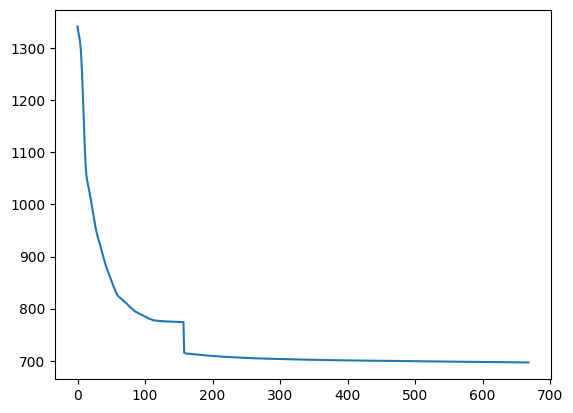

In [78]:
plt.plot(losses)

In [79]:
P_list_cpu = [(W @ W.T).cpu().data for W in W_list]
W_list_cpu = [W.cpu().data for W in W_list]

Text(0.5, 1.0, 'P(column in view)')

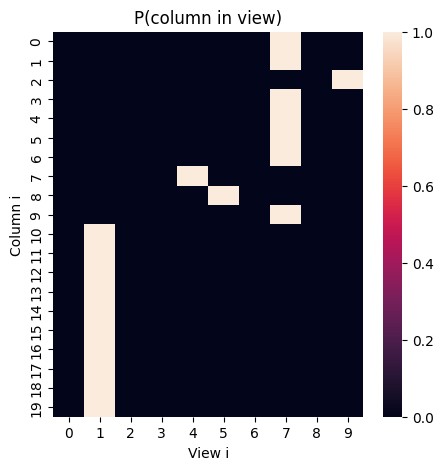

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5, 5))
sns.heatmap(eta, ax=ax)

ax.set_xlabel("View i")
ax.set_ylabel("Column i")
ax.set_title("P(column in view)")

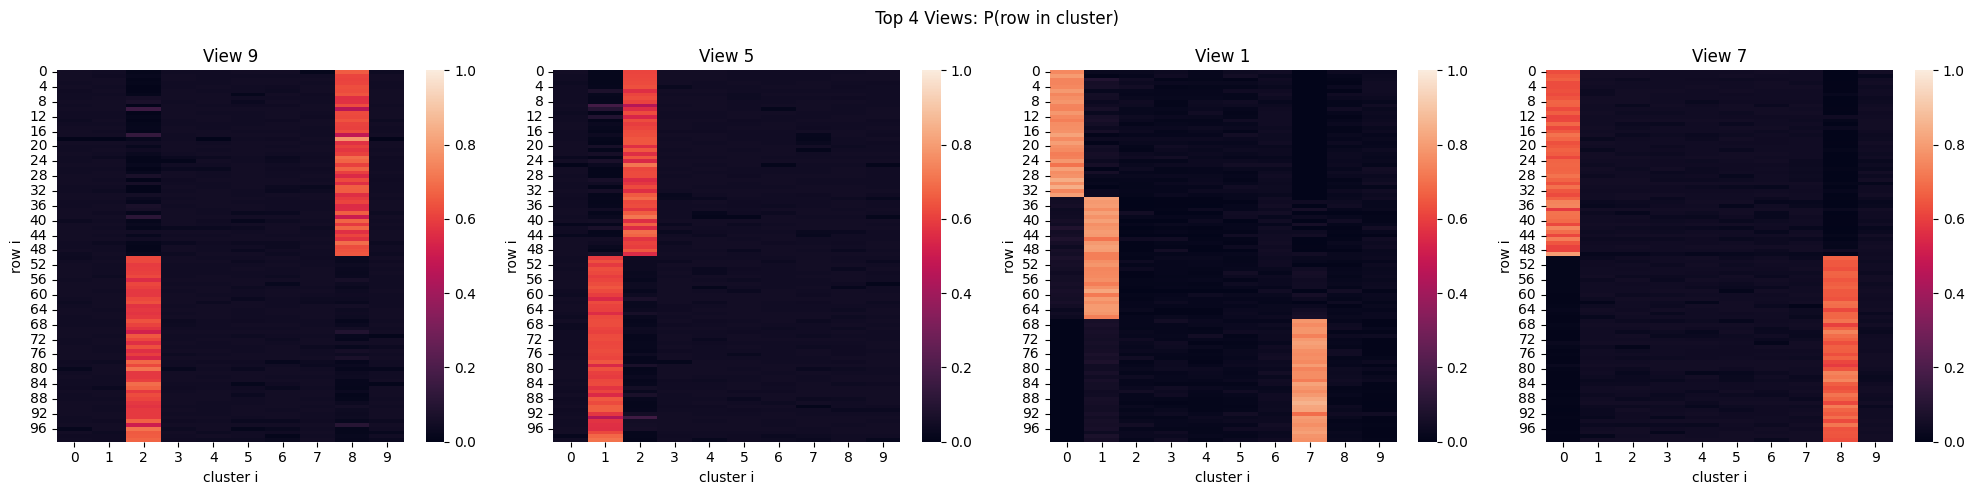

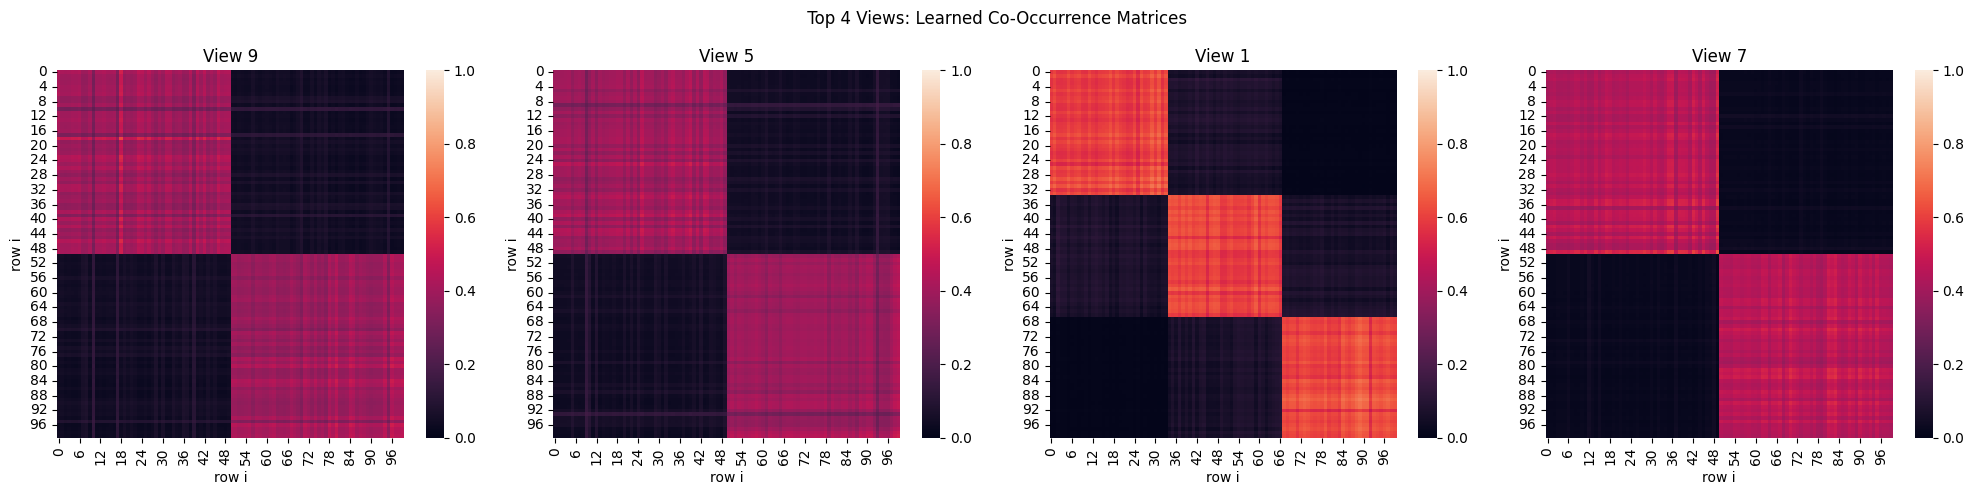

In [111]:
top_n_views = min(4, n_views)
top_n_views_ind = np.argpartition(lam, -top_n_views)[-top_n_views:]

fig, axs = plt.subplots(
    nrows=1, ncols=top_n_views, figsize=(20, 5)
)

fig.suptitle(f" Top {top_n_views} Views: P(row in cluster)")
for view_i, ax in zip(top_n_views_ind, axs.flatten()):
    sns.heatmap(W_list_cpu[view_i], ax=ax, vmin=0, vmax=1)

    ax.set_xlabel("cluster i")
    ax.set_ylabel("row i")
    ax.set_title(f"View {view_i}")
    
fig.tight_layout()

fig, axs = plt.subplots(
    nrows=1, ncols=top_n_views, figsize=(20, 5)
)

fig.suptitle(f" Top {top_n_views} Views: Learned Co-Occurrence Matrices")
for view_i, ax in zip(top_n_views_ind, axs.flatten()):
    sns.heatmap(P_list_cpu[view_i], ax=ax, vmin=0, vmax=1)

    ax.set_xlabel("row i")
    ax.set_ylabel("row i")
    ax.set_title(f"View {view_i}")
    
fig.tight_layout()